In [ ]:
# upload Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# facenet will be used to separate celeba into groups of images by person 10177 groups. that is the number of celebs.
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166

In [ ]:
!pip install --upgrade facenet-pytorch


In [ ]:
# Torch and related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Image and transformation libraries
from PIL import Image
import torchvision.transforms as transforms

# Transformers library (ViT and feature extraction)
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
import numpy as np
import pandas as pd

# Sklearn for splits and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Additional utilities
from tqdm import tqdm  # Progress bars
import time
import kagglehub
import os
import shutil

# Clustering (for KMeans feature clustering)
from sklearn.cluster import KMeans

# FaceNet for face embeddings (Pytorch version)
from facenet_pytorch import InceptionResnetV1, MTCNN


In [ ]:
# Download dataset
fake_dir = kagglehub.dataset_download("dullaz/1m-ai-generated-faces-128x128")
fake_path = os.path.join(fake_dir, "fake_faces_dataset")  # Path where images are downloaded

print(f"Dataset downloaded to: {fake_path}")


100%|██████████| 4.08G/4.08G [00:42<00:00, 103MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/dullaz/1m-ai-generated-faces-128x128/versions/5/fake_faces_dataset


In [ ]:
# Download Celeba data real images
real_dir = kagglehub.dataset_download("jessicali9530/celeba-dataset")
real_path = os.path.join(real_dir, "img_align_celeba/img_align_celeba")


100%|██████████| 1.33G/1.33G [00:16<00:00, 88.1MB/s]

Extracting files...


In [ ]:
# Load real and AI-generated image CSVs
real_csv_path = "/content/drive/MyDrive/w210/final_data/final_celeba_all_balanced.csv"
ai_csv_path = "/content/drive/MyDrive/w210/final_data/final_million_all_balanced.csv"

real_df = pd.read_csv(real_csv_path)
ai_df = pd.read_csv(ai_csv_path)

In [ ]:
real_df.columns

Index(['image_id', 'gender', 'image_path', 'age', 'region', 'ethnicity',
       'label'],
      dtype='object')

In [ ]:
ai_df.columns

Index(['image_id', 'image_path', 'region', 'age', 'ethnicity', 'gender',
       'label'],
      dtype='object')

In [ ]:
#reorder the columns to image_id, image_path, region, gender, ethnicity, age, label
real_df = real_df[["image_id", "image_path", "region", "gender", "ethnicity", "age", "label"]]
real_df.head()

,image_id,image_path,region,gender,ethnicity,age,label
0,139696.jpg,/root/.cache/kagglehub/datasets/jessicali9530/...,"{'x': 34, 'y': 67, 'w': 109, 'h': 109, 'left_e...",1,0,24,1
1,001854.jpg,/root/.cache/kagglehub/datasets/jessicali9530/...,"{'x': 39, 'y': 71, 'w': 101, 'h': 101, 'left_e...",1,1,46,1
2,189118.jpg,/root/.cache/kagglehub/datasets/jessicali9530/...,"{'x': 40, 'y': 71, 'w': 100, 'h': 100, 'left_e...",1,1,24,1
3,162763.jpg,/root/.cache/kagglehub/datasets/jessicali9530/...,"{'x': 37, 'y': 65, 'w': 109, 'h': 109, 'left_e...",1,0,42,1
4,004839.jpg,/root/.cache/kagglehub/datasets/jessicali9530/...,"{'x': 35, 'y': 64, 'w': 120, 'h': 120, 'left_e...",1,1,38,1


In [ ]:
#reorder the columns to image_id, image_path, region, gender, ethnicity, age, label
ai_df = ai_df[["image_id", "image_path", "region", "gender", "ethnicity", "age", "label"]]
ai_df.head()

,image_id,image_path,region,gender,ethnicity,age,label
0,ZPG8996YJ6.jpg,/root/.cache/kagglehub/datasets/dullaz/1m-ai-g...,"{'x': 20, 'y': 28, 'w': 88, 'h': 88, 'left_eye...",0,1,35,0
1,IM2M25SUU9.jpg,/root/.cache/kagglehub/datasets/dullaz/1m-ai-g...,"{'x': 16, 'y': 24, 'w': 95, 'h': 95, 'left_eye...",1,1,30,0
2,MUFPGBRPVK.jpg,/root/.cache/kagglehub/datasets/dullaz/1m-ai-g...,"{'x': 20, 'y': 23, 'w': 93, 'h': 93, 'left_eye...",1,1,26,0
3,6Y2OXVOK4X.jpg,/root/.cache/kagglehub/datasets/dullaz/1m-ai-g...,"{'x': 19, 'y': 27, 'w': 85, 'h': 85, 'left_eye...",1,1,30,0
4,5xpkLy6xbmrCXn6wa6gqmfC9pE16Ct9g.jpeg,/root/.cache/kagglehub/datasets/dullaz/1m-ai-g...,"{'x': 18, 'y': 23, 'w': 93, 'h': 93, 'left_eye...",1,0,30,0


In [ ]:
ai_df["age_bin"] = pd.cut(ai_df["age"], bins=[0, 31.71, float("inf")], labels=["below_mean", "above_mean"])
real_df["age_bin"] = pd.cut(real_df["age"], bins=[0, 31.71, float("inf")], labels=["below_mean", "above_mean"])

In [ ]:
# Load pre-trained FaceNet model
model = InceptionResnetV1(pretrained='vggface2').eval().cuda()  # Load on GPU

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Size expected by FaceNet
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

embeddings = []
paths = []

# Loop through images and extract embeddings
for idx, row in tqdm(real_df.iterrows(), total=len(real_df)):
    image_path = row['image_path']
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).cuda()  # Add batch dimension
    with torch.no_grad():
        emb = model(image).cpu().numpy().flatten()  # Extract embedding
    embeddings.append(emb)
    paths.append(image_path)

# Convert to array
embeddings = np.array(embeddings)


  0%|          | 0.00/107M [00:00<?, ?B/s]

100%|██████████| 39700/39700 [13:26<00:00, 49.24it/s]


In [ ]:
# Number of unique identities in CelebA
n_clusters = 10177
# Fit KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add clusters back to dataframe
real_df['cluster_id'] = clusters

# Save for later use
real_df.to_csv('/content/drive/MyDrive/w210/final_data/celeba_with_clusters.csv', index=False)


In [ ]:
real_df.columns

Index(['image_id', 'image_path', 'region', 'gender', 'ethnicity', 'age',
       'label', 'age_bin', 'cluster_id'],
      dtype='object')

In [ ]:
ai_df.columns

Index(['image_id', 'image_path', 'region', 'gender', 'ethnicity', 'age',
       'label', 'age_bin'],
      dtype='object')

In [ ]:
# Get unique clusters
unique_clusters = real_df['cluster_id'].unique()

# Split clusters
train_clusters, temp_clusters = train_test_split(unique_clusters, test_size=0.3, random_state=42)
val_clusters, test_clusters = train_test_split(temp_clusters, test_size=0.5, random_state=42)

# Assign images to splits
train_df = real_df[real_df['cluster_id'].isin(train_clusters)]
val_df = real_df[real_df['cluster_id'].isin(val_clusters)]
test_df = real_df[real_df['cluster_id'].isin(test_clusters)]

# Save splits
train_df.to_csv('/content/drive/MyDrive/w210/final_data/train_real_data_no_identity_leak.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/w210/final_data/val_real_data_no_identity_leak.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/w210/final_data/test_real_data_no_identity_leak.csv', index=False)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 27727, Val: 5927, Test: 6046


In [ ]:

# Paths to your CSV splits
save_dir = "/content/drive/MyDrive/w210/final_data"
train_path = f"{save_dir}/train_real_data_no_identity_leak.csv"
val_path = f"{save_dir}/val_real_data_no_identity_leak.csv"
test_path = f"{save_dir}/test_real_data_no_identity_leak.csv"

# Load datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Function to check group distributions
def count_groups(df, dataset_name):
    print(f"\n Distribution in {dataset_name} dataset:")
    print("-" * 50)
    print("\n Gender Count:")
    print(df["gender"].value_counts(), "\n")

    print(" Ethnicity Count:")
    print(df["ethnicity"].value_counts(), "\n")

    print(" Age Bin Count:")
    print(df["age_bin"].value_counts(), "\n")

    print(" Label Count (0=AI, 1=Real):")
    print(df["label"].value_counts(), "\n")

# Run for each dataset
count_groups(train_df, "Train")
count_groups(val_df, "Validation")
count_groups(test_df, "Test")



 Distribution in Train dataset:
--------------------------------------------------

 Gender Count:
gender
1    14367
0    13360
Name: count, dtype: int64 

 Ethnicity Count:
ethnicity
1    13901
0    13826
Name: count, dtype: int64 

 Age Bin Count:
age_bin
above_mean    14381
below_mean    13346
Name: count, dtype: int64 

 Label Count (0=AI, 1=Real):
label
1    27727
Name: count, dtype: int64 


 Distribution in Validation dataset:
--------------------------------------------------

 Gender Count:
gender
1    3185
0    2742
Name: count, dtype: int64 

 Ethnicity Count:
ethnicity
1    3000
0    2927
Name: count, dtype: int64 

 Age Bin Count:
age_bin
above_mean    3245
below_mean    2682
Name: count, dtype: int64 

 Label Count (0=AI, 1=Real):
label
1    5927
Name: count, dtype: int64 


 Distribution in Test dataset:
--------------------------------------------------

 Gender Count:
gender
1    3368
0    2678
Name: count, dtype: int64 

 Ethnicity Count:
ethnicity
0    3097
1    294

In [ ]:
# Create a combined stratification column from gender, ethnicity, and age_bin
ai_df["stratify_group"] = ai_df[["gender", "ethnicity", "age_bin"]].astype(str).agg("_".join, axis=1)


In [ ]:
# First split: Train and Temp (Val + Test)
ai_train, ai_temp = train_test_split(
    ai_df,
    test_size=0.3,
    stratify=ai_df["stratify_group"],
    random_state=42
)

In [ ]:
# Second split: Validation and Test (each 15% of total, i.e., 50% of Temp)
ai_val, ai_test = train_test_split(
    ai_temp,
    test_size=0.5,  # Half of Temp
    stratify=ai_temp["stratify_group"],
    random_state=42
)

In [ ]:
print(f"AI Train size: {len(ai_train)}")
print(f"AI Validation size: {len(ai_val)}")
print(f"AI Test size: {len(ai_test)}")

# check balance
def check_balance(df, name="Dataset"):
    print(f"\n{name} Gender Distribution:\n", df['gender'].value_counts())
    print(f"{name} Ethnicity Distribution:\n", df['ethnicity'].value_counts())
    print(f"{name} Age Bin Distribution:\n", df['age_bin'].value_counts())
    print(f"{name} Label Distribution:\n", df['label'].value_counts())

check_balance(ai_train, "AI Train")
check_balance(ai_val, "AI Validation")
check_balance(ai_test, "AI Test")


AI Train size: 27790
AI Validation size: 5955
AI Test size: 5955

AI Train Gender Distribution:
 gender
1    14535
0    13255
Name: count, dtype: int64
AI Train Ethnicity Distribution:
 ethnicity
1    13895
0    13895
Name: count, dtype: int64
AI Train Age Bin Distribution:
 age_bin
below_mean    18149
above_mean     9641
Name: count, dtype: int64
AI Train Label Distribution:
 label
0    27790
Name: count, dtype: int64

AI Validation Gender Distribution:
 gender
1    3115
0    2840
Name: count, dtype: int64
AI Validation Ethnicity Distribution:
 ethnicity
0    2978
1    2977
Name: count, dtype: int64
AI Validation Age Bin Distribution:
 age_bin
below_mean    3889
above_mean    2066
Name: count, dtype: int64
AI Validation Label Distribution:
 label
0    5955
Name: count, dtype: int64

AI Test Gender Distribution:
 gender
1    3114
0    2841
Name: count, dtype: int64
AI Test Ethnicity Distribution:
 ethnicity
1    2978
0    2977
Name: count, dtype: int64
AI Test Age Bin Distribution:
 ag

In [ ]:
# Drop stratify column
ai_train = ai_train.drop(columns=['stratify_group'])
ai_val = ai_val.drop(columns=['stratify_group'])
ai_test = ai_test.drop(columns=['stratify_group'])

# Save
save_dir = '/content/drive/MyDrive/w210/final_data'

ai_train.to_csv(f"{save_dir}/ai_train_data.csv", index=False)
ai_val.to_csv(f"{save_dir}/ai_val_data.csv", index=False)
ai_test.to_csv(f"{save_dir}/ai_test_data.csv", index=False)

print("AI datasets saved successfully.")


AI datasets saved successfully.


In [ ]:
#read ai datasets
ai_train_df = pd.read_csv(f"{save_dir}/ai_train_data.csv")
ai_val_df = pd.read_csv(f"{save_dir}/ai_val_data.csv")
ai_test_df = pd.read_csv(f"{save_dir}/ai_test_data.csv")

In [ ]:
# Suppress Seaborn FutureWarnings for palette/hue
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_balances_multiple_sets_custom(real_train, real_val, real_test, ai_train, ai_val, ai_test):
    sets = {
        'Real Train': real_train,
        'Real Val': real_val,
        'Real Test': real_test,
        'AI Train': ai_train,
        'AI Val': ai_val,
        'AI Test': ai_test
    }

    # Define custom palettes for each feature
    gender_palette = {'1': 'blue', '0': 'pink'}  # 1: male (blue), 0: female (pink)
    ethnicity_palette = {'1': '#f5deb3', '0': '#8b4513'}  # 1: light skin, 0: dark skin
    age_palette = {'below_mean': '#b0b0b0', 'above_mean': '#505050'}  # Grayscale

    # Map of feature names to palettes
    palette_map = {
        'gender': gender_palette,
        'ethnicity': ethnicity_palette,
        'age_bin': age_palette
    }

    features = ['gender', 'ethnicity', 'age_bin']

    # Loop through features and plot for each set
    for feature in features:
        plt.figure(figsize=(18, 5))
        for idx, (set_name, df) in enumerate(sets.items(), 1):
            plt.subplot(1, 6, idx)

            # Handle gender and ethnicity as strings for correct palette mapping
            if feature in ['gender', 'ethnicity']:
                df[feature] = df[feature].astype(str)

            sns.countplot(
                x=feature,
                data=df,
                palette=palette_map[feature],
                order=sorted(df[feature].unique())
            )
            plt.title(f'{set_name}\n({feature})', fontsize=11)
            plt.xlabel('')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
        plt.suptitle(f'Distribution of {feature.capitalize()} Across Sets', fontsize=16, weight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title space
        plt.show()

    # ---------------- Plot label distribution ----------------
    if 'label' in real_train.columns:
        plt.figure(figsize=(18, 5))
        for idx, (set_name, df) in enumerate(sets.items(), 1):
            plt.subplot(1, 6, idx)
            sns.countplot(x='label', data=df, palette='Set1')
            plt.title(f'{set_name}\n(Label)', fontsize=11)
            plt.xlabel('')
            plt.ylabel('Count')
        plt.suptitle('Label Distribution Across Sets', fontsize=16, weight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


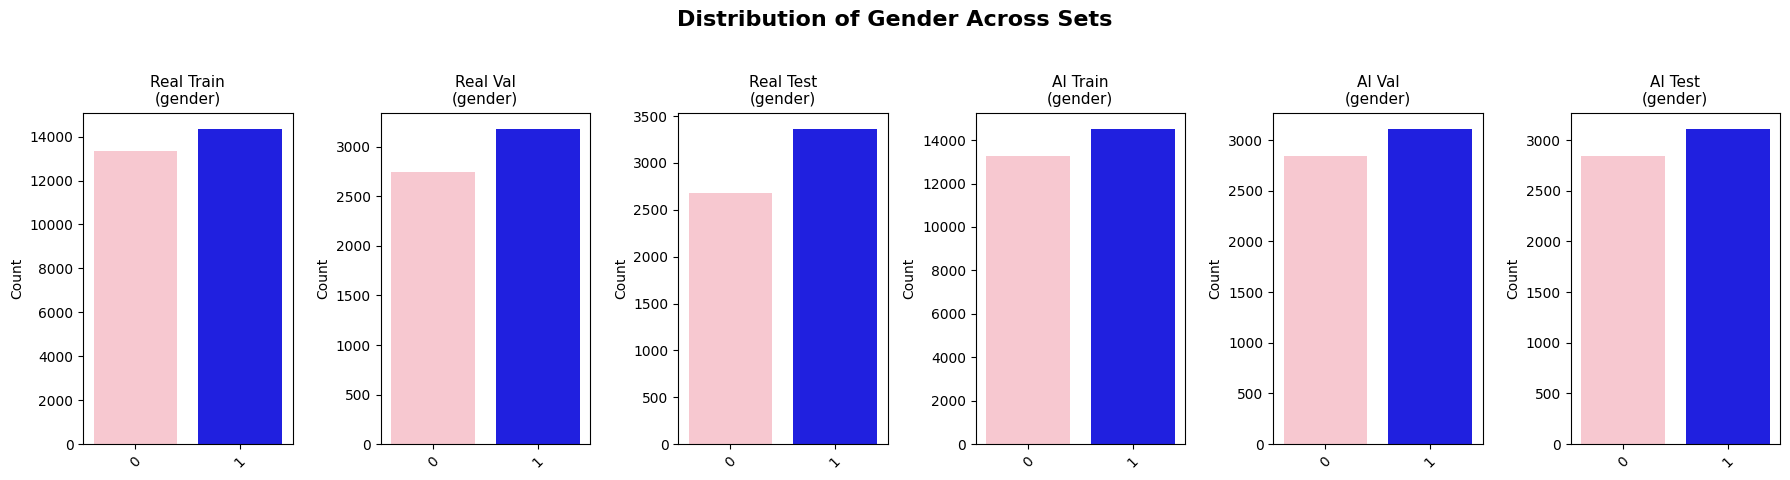

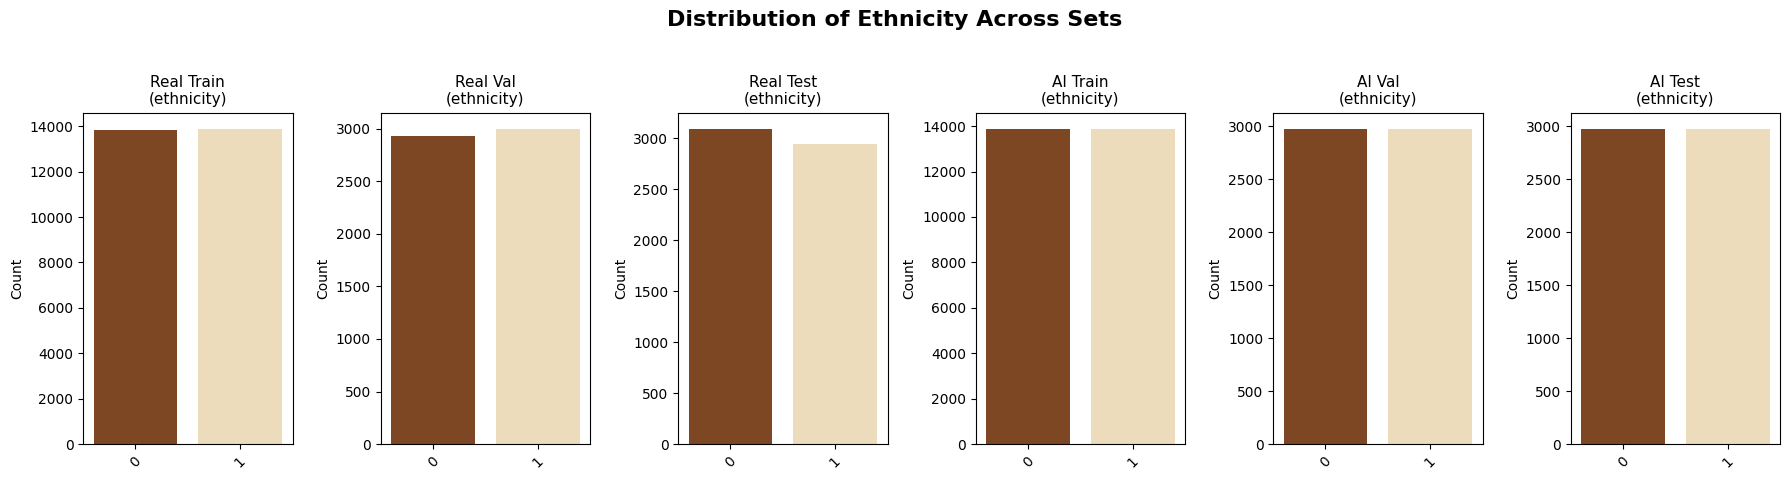

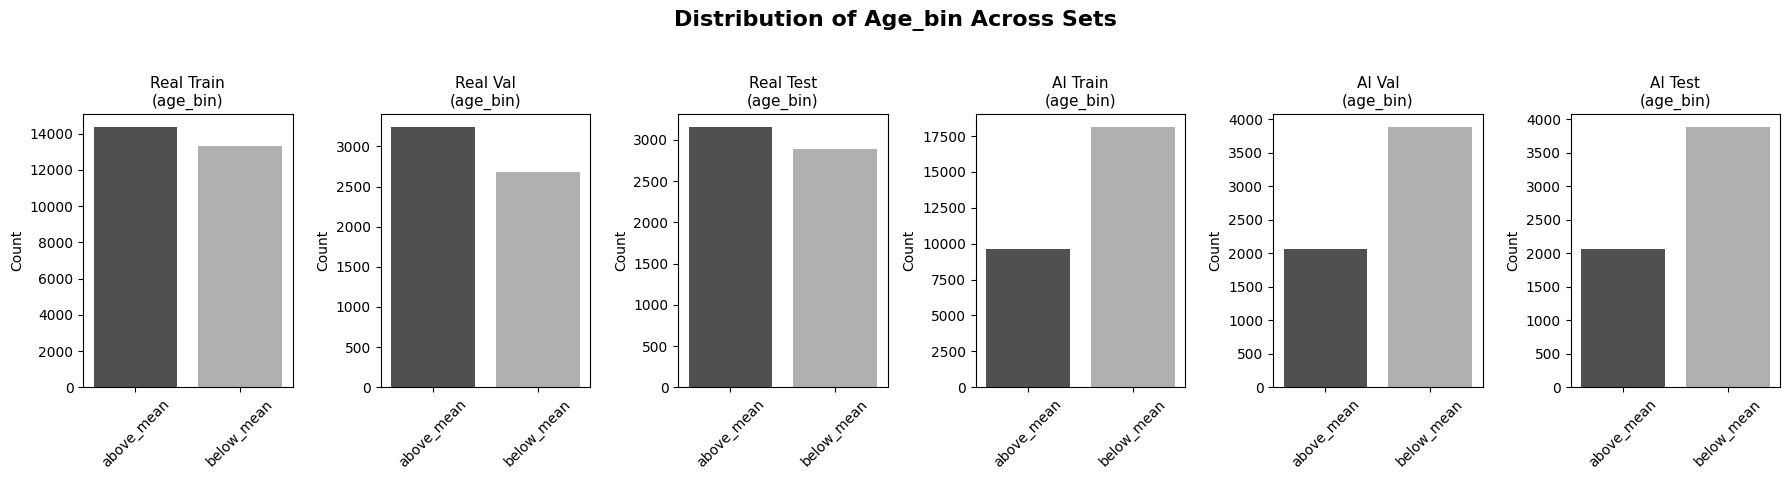

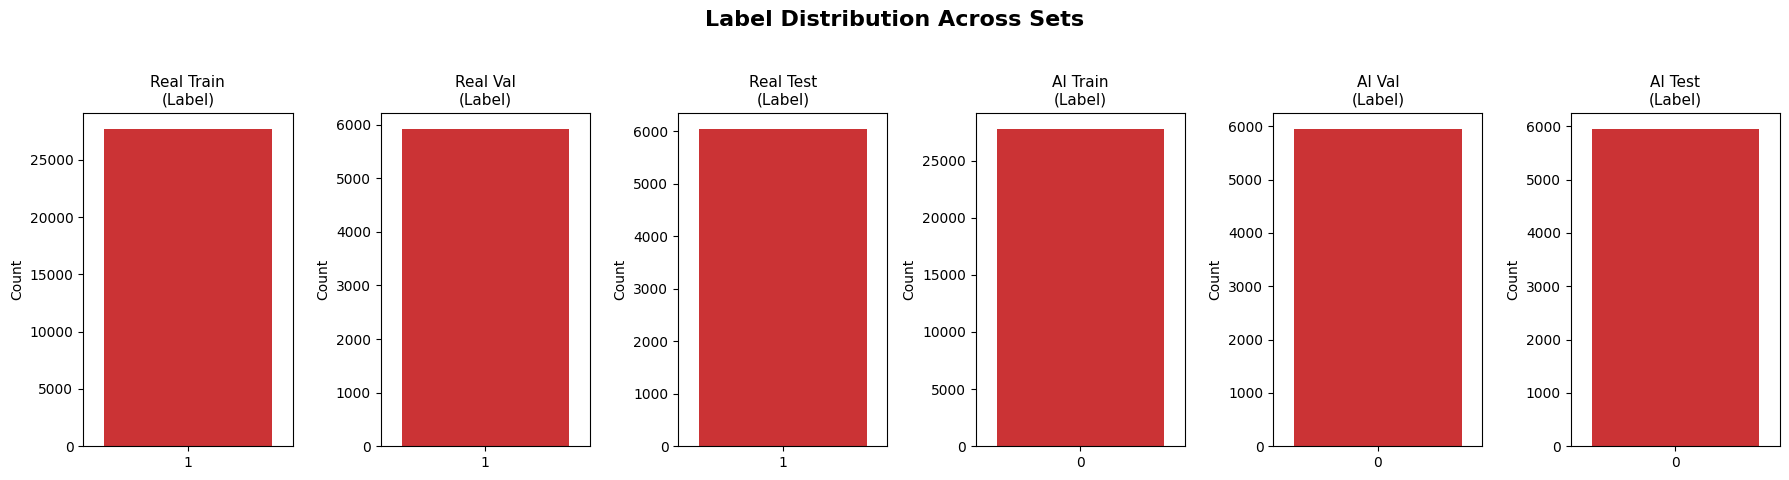

In [ ]:
plot_balances_multiple_sets_custom(train_df, val_df, test_df,
                            ai_train_df, ai_val_df, ai_test_df)


In [ ]:
# Combine Real and AI datasets by split
combined_train_df = pd.concat([train_df, ai_train_df], ignore_index=True)
combined_val_df = pd.concat([val_df, ai_val_df], ignore_index=True)
combined_test_df = pd.concat([test_df, ai_test_df], ignore_index=True)

print(f"Train: {len(combined_train_df)}, Val: {len(combined_val_df)}, Test: {len(combined_test_df)}")

Train: 55517, Val: 11882, Test: 12001


In [ ]:
# Shuffle datasets
combined_train_df = combined_train_df.sample(frac=1, random_state=42).reset_index(drop=True)
combined_val_df = combined_val_df.sample(frac=1, random_state=42).reset_index(drop=True)
combined_test_df = combined_test_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Define base image directory
image_dir = '/content/drive/MyDrive/w210/final_data/all_images/'

# Add full path to images
for df in [combined_train_df, combined_val_df, combined_test_df]:
    df['image_filename'] = df['image_path'].apply(lambda x: os.path.join(image_dir, x))


In [ ]:
# Final column order
column_order = ['image_filename', 'cluster_id', 'region', 'gender', 'ethnicity', 'age', 'age_bin', 'label']

# Function to clean and reorder columns
def clean_and_reorder_columns(df, column_order):
    # Keep only columns that are in column_order and present in df
    available_columns = [col for col in column_order if col in df.columns]
    # Drop columns not in column_order
    df = df[available_columns]
    return df

# Apply function to each combined dataset
combined_train_df = clean_and_reorder_columns(combined_train_df, column_order)
combined_val_df = clean_and_reorder_columns(combined_val_df, column_order)
combined_test_df = clean_and_reorder_columns(combined_test_df, column_order)

# Check result
print("Train columns:", combined_train_df.columns.tolist())
print("Validation columns:", combined_val_df.columns.tolist())
print("Test columns:", combined_test_df.columns.tolist())


Train columns: ['image_filename', 'cluster_id', 'region', 'gender', 'ethnicity', 'age', 'age_bin', 'label']
Validation columns: ['image_filename', 'cluster_id', 'region', 'gender', 'ethnicity', 'age', 'age_bin', 'label']
Test columns: ['image_filename', 'cluster_id', 'region', 'gender', 'ethnicity', 'age', 'age_bin', 'label']


In [ ]:
# Define save directory
save_dir = "/content/drive/MyDrive/w210/final_data/combined_splits"

# Create directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save CSVs
combined_train_df.to_csv(os.path.join(save_dir, 'combined_train_data.csv'), index=False)
combined_val_df.to_csv(os.path.join(save_dir, 'combined_val_data.csv'), index=False)
combined_test_df.to_csv(os.path.join(save_dir, 'combined_test_data.csv'), index=False)

print("Combined and cleaned datasets saved successfully at:")
print(f"- {os.path.join(save_dir, 'combined_train_data.csv')}")
print(f"- {os.path.join(save_dir, 'combined_val_data.csv')}")
print(f"- {os.path.join(save_dir, 'combined_test_data.csv')}")


Combined and cleaned datasets saved successfully at:
- /content/drive/MyDrive/w210/final_data/combined_splits/combined_train_data.csv
- /content/drive/MyDrive/w210/final_data/combined_splits/combined_val_data.csv
- /content/drive/MyDrive/w210/final_data/combined_splits/combined_test_data.csv


In [ ]:
#read combined_df's
combined_train_df = pd.read_csv(f"{save_dir}/combined_train_data.csv")
combined_val_df = pd.read_csv(f"{save_dir}/combined_val_data.csv")
combined_test_df = pd.read_csv(f"{save_dir}/combined_test_data.csv")

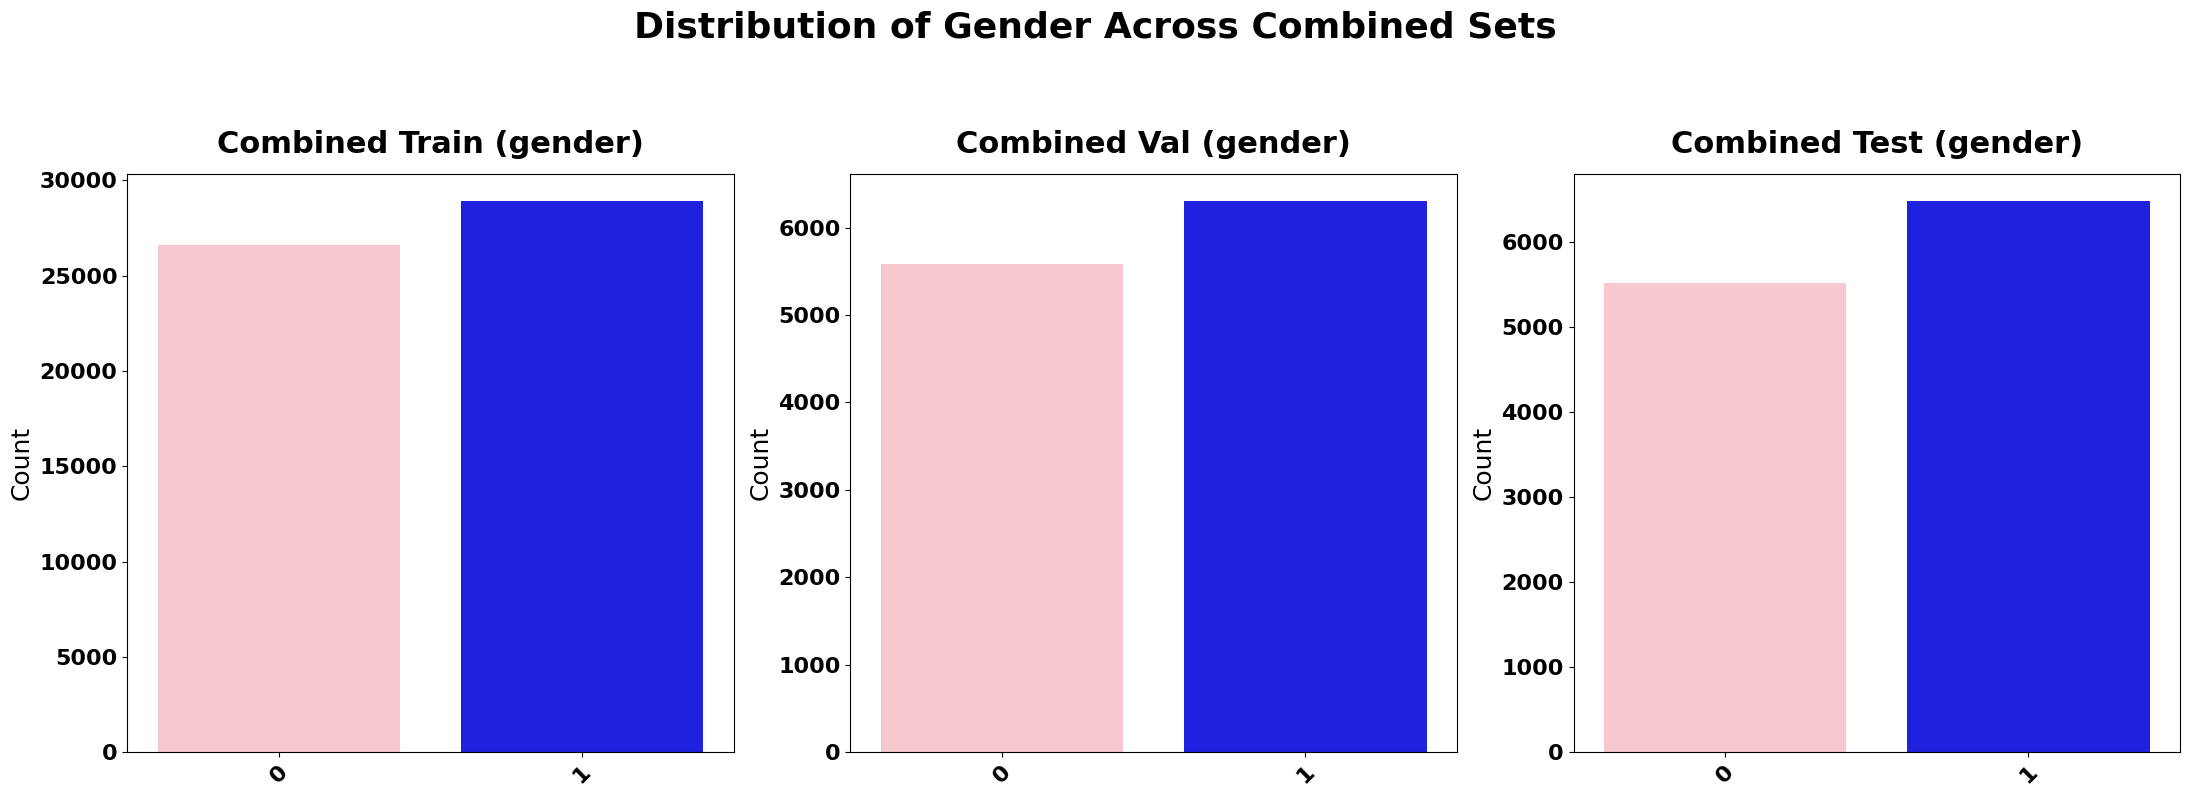

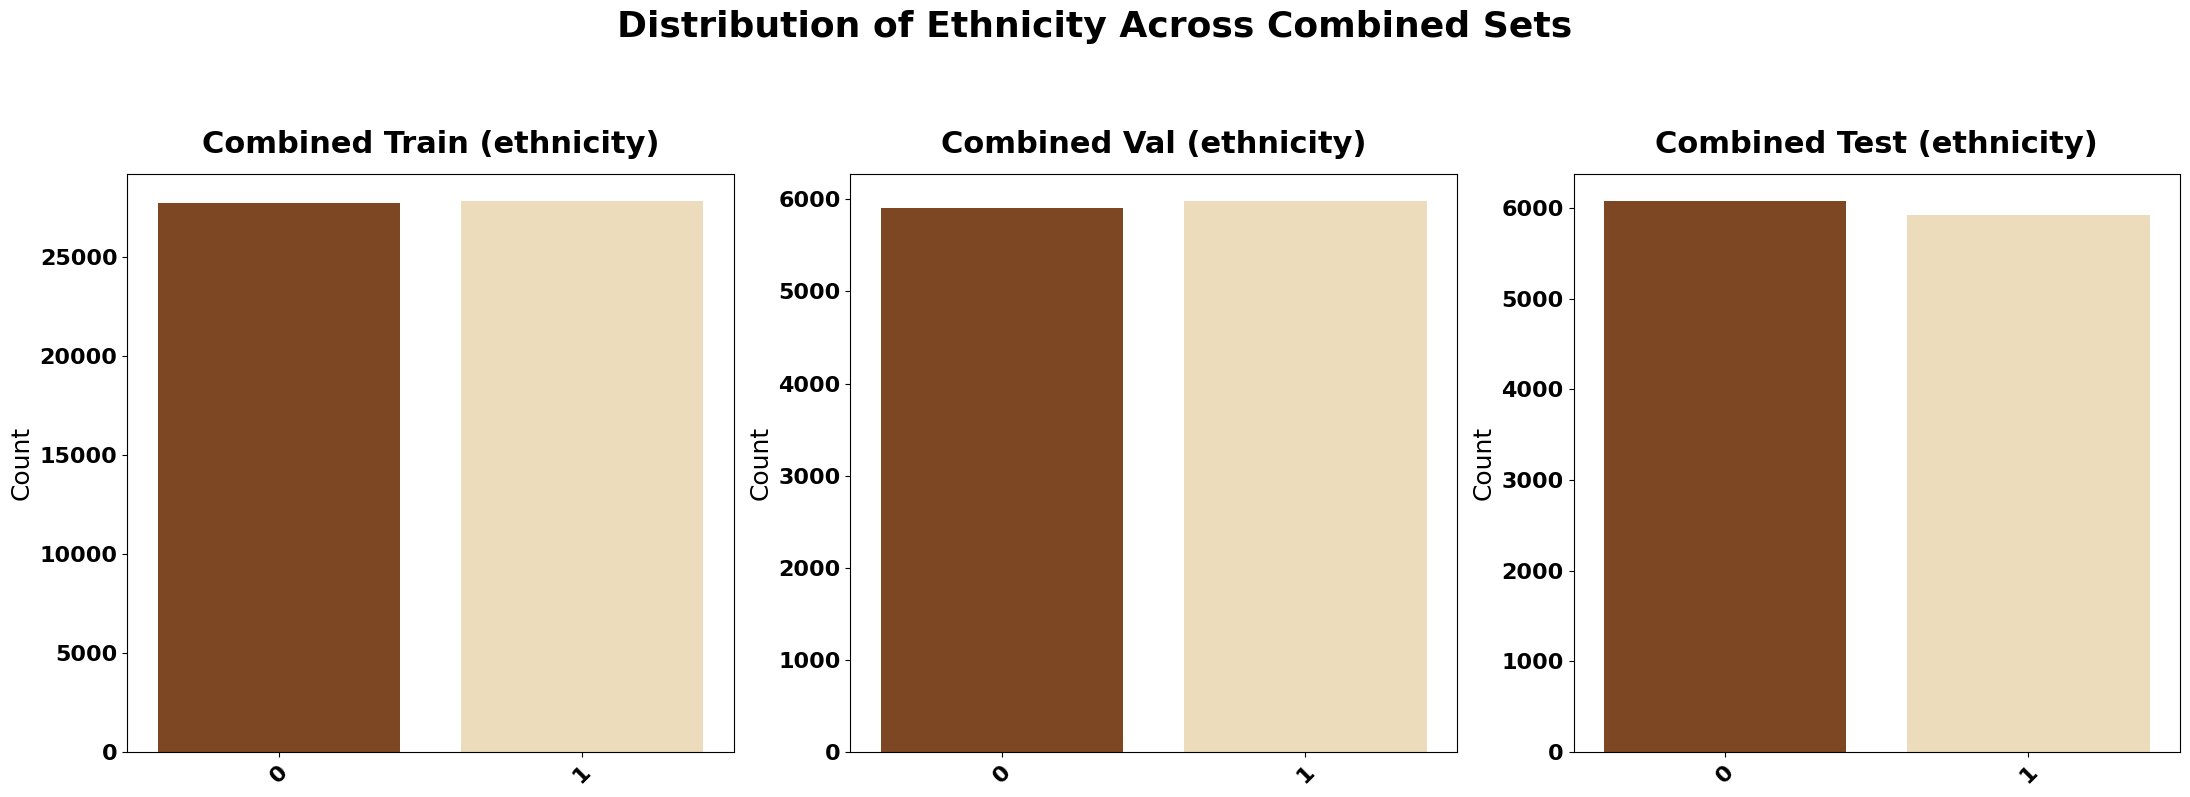

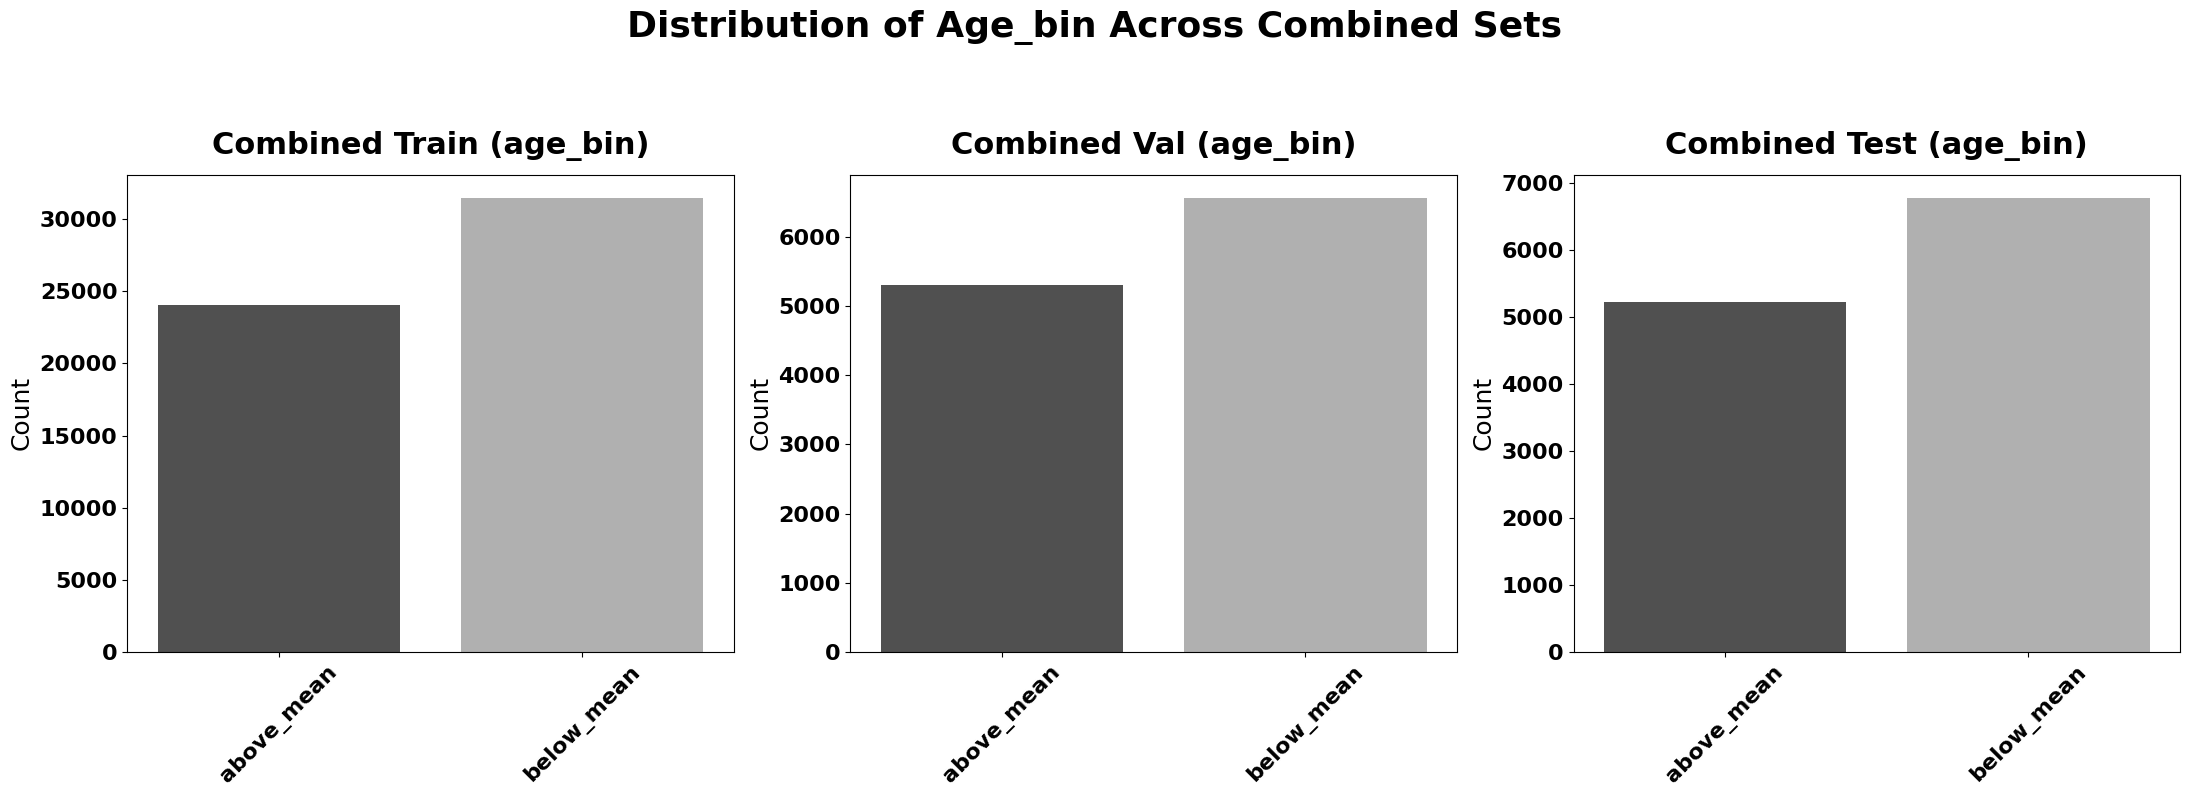

In [ ]:
# Custom palettes
gender_palette = {'1': 'blue', '0': 'pink'}               # Gender: 1 = blue (male), 0 = pink (female)
ethnicity_palette = {'1': '#f5deb3', '0': '#8b4513'}     # Ethnicity: 1 = light skin, 0 = dark skin
age_palette = {'below_mean': '#b0b0b0', 'above_mean': '#505050'}  # Age bins as gray shades

# Function to ensure consistent types for mapping
def ensure_string_columns(df, columns):
    for col in columns:
        df[col] = df[col].astype(str)
    return df

# Apply string conversion for categorical plotting
combined_train_df = ensure_string_columns(combined_train_df, ['gender', 'ethnicity', 'age_bin'])
combined_val_df = ensure_string_columns(combined_val_df, ['gender', 'ethnicity', 'age_bin'])
combined_test_df = ensure_string_columns(combined_test_df, ['gender', 'ethnicity', 'age_bin'])

# Mapping of feature to palette
palette_map = {
    'gender': gender_palette,
    'ethnicity': ethnicity_palette,
    'age_bin': age_palette
}

# List of combined datasets for looping
combined_sets = {
    'Combined Train': combined_train_df,
    'Combined Val': combined_val_df,
    'Combined Test': combined_test_df
}

# Function to plot each feature across all datasets
def plot_combined_distributions(sets, features, palette_map):
    for feature in features:
        plt.figure(figsize=(22, 8))
        for idx, (set_name, df) in enumerate(sets.items(), 1):
            plt.subplot(1, 3, idx)  # 3 plots for train, val, test
            sns.countplot(
                x=feature,
                data=df,
                palette=palette_map[feature],
                order=sorted(df[feature].unique())
            )
            plt.title(f'{set_name} ({feature})', fontsize=22, weight='bold', pad=15)
            plt.xlabel('', fontsize=18)
            plt.ylabel('Count', fontsize=18)
            plt.xticks(fontsize=16, rotation=45, weight='bold')
            plt.yticks(fontsize=16, weight='bold')
        plt.suptitle(f'Distribution of {feature.capitalize()} Across Combined Sets', fontsize=26, weight='bold', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Features to plot
features_to_plot = ['gender', 'ethnicity', 'age_bin']

plot_combined_distributions(combined_sets, features_to_plot, palette_map)


In [ ]:
# Define the file paths
save_dir = "/content/drive/MyDrive/w210/final_data/combined_splits"
train_path = f"{save_dir}/combined_train_data.csv"
val_path = f"{save_dir}/combined_val_data.csv"
test_path = f"{save_dir}/combined_test_data.csv"

# Load the datasets
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)


In [ ]:
# Preprocess images
# Define image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class to load images and labels from CSV
class RealVsAIDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir  # Path to unified images folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_filename = self.data.iloc[idx]['image_filename']  # e.g., '00001.jpg'
        img_path = os.path.join(self.image_dir, img_filename)  # Full path

        label = self.data.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Path to unified image folder
image_dir = "/content/drive/MyDrive/w210/final_data/all_images"

# Create datasets and apply transform
train_dataset = RealVsAIDataset("/content/drive/MyDrive/w210/final_data/combined_splits/combined_train_data.csv", image_dir=image_dir, transform=transform)
val_dataset = RealVsAIDataset("/content/drive/MyDrive/w210/final_data/combined_splits/combined_val_data.csv", image_dir=image_dir, transform=transform)
test_dataset = RealVsAIDataset("/content/drive/MyDrive/w210/final_data/combined_splits/combined_test_data.csv", image_dir=image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 55517, Val: 11882, Test: 12001


In [ ]:
# Load Pretrained ViT Model (with handling for classifier head mismatch)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True  # Fix mismatch issue for classifier layer
)
model.to("cuda")  # Move to GPU if available
# Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training Loop
num_epochs = 5
total_start_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start epoch timer

    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")  # Move tensors to GPU

        # Convert labels to one-hot encoding (needed for BCEWithLogitsLoss)
        labels = torch.nn.functional.one_hot(labels, num_classes=2).float()

        optimizer.zero_grad()
        outputs = model(images).logits  # Get logits
        loss = criterion(outputs, labels)  # Compute BCE loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.argmax(outputs, dim=1)
        true_labels = torch.argmax(labels, dim=1)
        correct += (predictions == true_labels).sum().item()

    # Compute average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_dataset)
    epoch_time = time.time() - epoch_start_time  # Time for this epoch

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Acc: {accuracy:.4f} | Time: {epoch_time:.2f} seconds")

total_training_time = time.time() - total_start_time  # Total training time
print(f"\n Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5] | Loss: 0.0102 | Acc: 0.9980 | Time: 1895.96 seconds
Epoch [2/5] | Loss: 0.0008 | Acc: 0.9998 | Time: 1865.27 seconds
Epoch [3/5] | Loss: 0.0008 | Acc: 0.9998 | Time: 1835.60 seconds
Epoch [4/5] | Loss: 0.0003 | Acc: 0.9999 | Time: 1834.98 seconds
Epoch [5/5] | Loss: 0.0000 | Acc: 1.0000 | Time: 1836.52 seconds

 Total Training Time: 9268.33 seconds (154.47 minutes)


In [ ]:
# Save the trained model
model.save_pretrained("/content/drive/MyDrive/w210/final_data/my_combined_trained_vit")

In [ ]:
# Load the trained model for inference
model = ViTForImageClassification.from_pretrained("/content/drive/MyDrive/w210/final_data/my_combined_trained_vit")
model.to("cuda")  # Move to GPU if using GPU
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Load the CSV
csv_df = pd.read_csv("/content/drive/MyDrive/w210/final_data/final_million_all_balanced.csv")

# Inspect first few rows
print(csv_df.head())

                                image_id  \
0                         ZPG8996YJ6.jpg   
1                         IM2M25SUU9.jpg   
2                         MUFPGBRPVK.jpg   
3                         6Y2OXVOK4X.jpg   
4  5xpkLy6xbmrCXn6wa6gqmfC9pE16Ct9g.jpeg   

                                          image_path  \
0  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
1  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
2  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
3  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   
4  /root/.cache/kagglehub/datasets/dullaz/1m-ai-g...   

                                              region  age  ethnicity  gender  \
0  {'x': 20, 'y': 28, 'w': 88, 'h': 88, 'left_eye...   35          1       0   
1  {'x': 16, 'y': 24, 'w': 95, 'h': 95, 'left_eye...   30          1       1   
2  {'x': 20, 'y': 23, 'w': 93, 'h': 93, 'left_eye...   26          1       1   
3  {'x': 19, 'y': 27, 'w': 85, 'h': 85, 'left_eye...   30          1       1  

In [ ]:
def evaluate_model_with_plots(model, data_loader, dataset_df, group_cols=["gender", "ethnicity"], plot_title=''):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images).logits
            probs = torch.sigmoid(outputs)

            # Store probabilities for class 1 (Real)
            probs_real = probs[:, 1].detach().cpu().numpy()

            preds = (probs_real >= 0.5).astype(int)  # Threshold at 0.5
            labels = labels.cpu().numpy()

            all_labels.extend(labels)
            all_probs.extend(probs_real)
            all_preds.extend(preds)

    # ---------------------- Metrics Calculation ----------------------
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"\n Overall Metrics:")
    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # ---------------------- ROC Curve ----------------------
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

    plt.xlabel('False Positive Rate', fontsize=17)
    plt.ylabel('True Positive Rate', fontsize=17)
    plt.title('ROC Curve ' + plot_title, fontsize=22, weight='bold')
    plt.legend(loc="lower right", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.show()

    # ---------------------- Confusion Matrix ----------------------
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-Generated", "Real"])
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)

    plt.title('Confusion Matrix ' + plot_title, fontsize=22, weight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Predicted label', fontsize=17)
    plt.ylabel('True label', fontsize=17)
    plt.show()

    # ---------------------- Group-wise Analysis ----------------------
    print("\n Group-wise performance (gender/ethnicity):")

    # Map back predictions to DataFrame
    dataset_df = dataset_df.reset_index(drop=True).copy()
    dataset_df['true_label'] = all_labels
    dataset_df['predicted_label'] = all_preds
    dataset_df['probability_real'] = all_probs

    # Group by gender/ethnicity
    grouped = dataset_df.groupby(group_cols)
    for group_name, group_df in grouped:
        group_acc = accuracy_score(group_df['true_label'], group_df['predicted_label'])
        try:
            group_auc = roc_auc_score(group_df['true_label'], group_df['probability_real'])
        except ValueError:
            group_auc = float('nan')
        print(f"Group {group_name}: Accuracy = {group_acc:.4f}, AUC = {group_auc:.4f}")

    return acc, auc, f1, precision, recall, all_labels, all_probs, all_preds


In [ ]:
# Load validation CSV
val_df = pd.read_csv("/content/drive/MyDrive/w210/final_data/combined_splits/combined_val_data.csv")

Evaluating: 100%|██████████| 372/372 [02:18<00:00,  2.69it/s]



 Overall Metrics:
Accuracy: 1.0000, AUC: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000


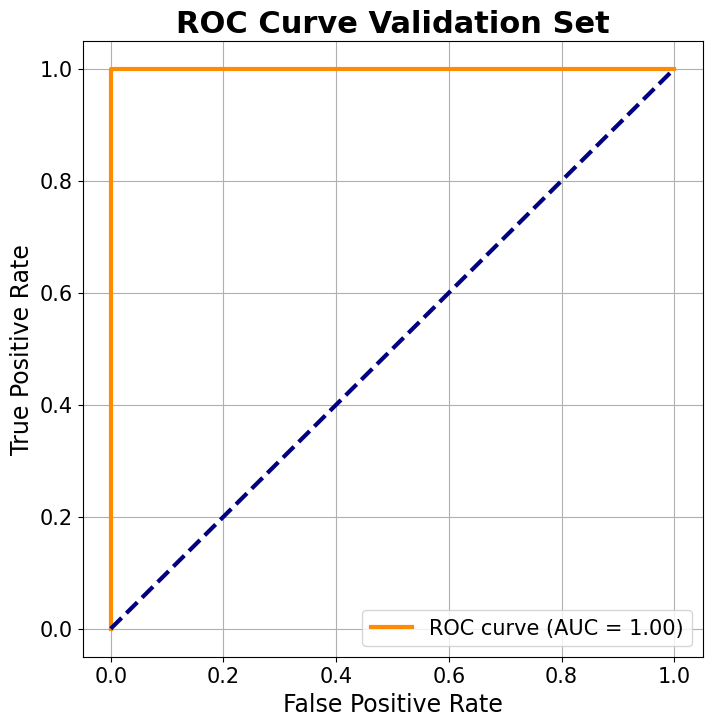

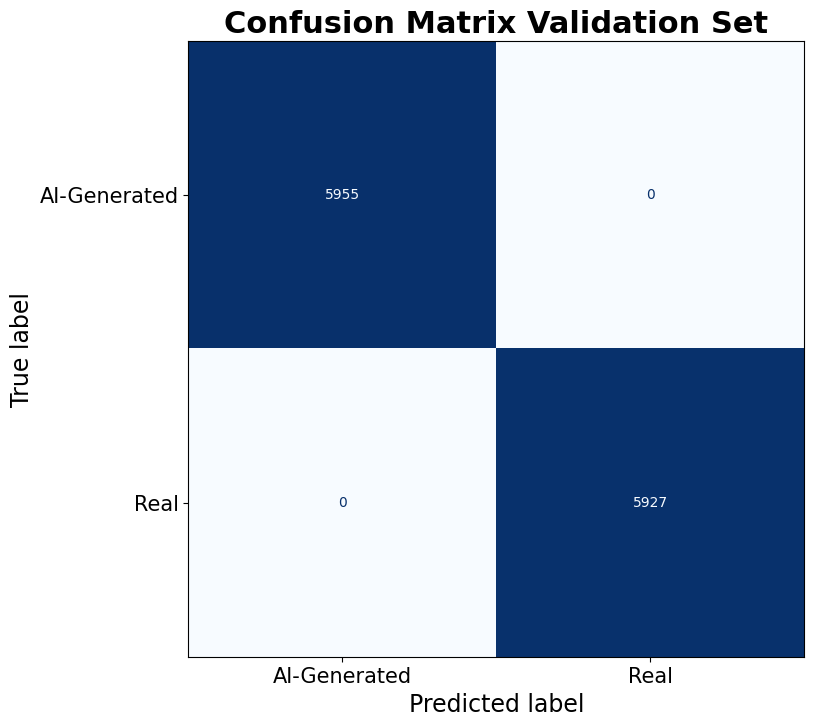


 Group-wise performance (gender/ethnicity):
Group (0, 0): Accuracy = 1.0000, AUC = 1.0000
Group (0, 1): Accuracy = 1.0000, AUC = 1.0000
Group (1, 0): Accuracy = 1.0000, AUC = 1.0000
Group (1, 1): Accuracy = 1.0000, AUC = 1.0000


In [ ]:
# Run the evaluation and capture outputs
acc, auc, f1, precision, recall, all_labels, all_probs, all_preds = evaluate_model_with_plots(
    model, val_loader, val_df, group_cols=["gender", "ethnicity"], plot_title='Validation Set'
)


In [ ]:
import pickle

# Save for later
with open('/content/drive/MyDrive/w210/final_data/combined_splits/eval_results_3_12.pkl', 'wb') as f:
    pickle.dump({'labels': all_labels, 'probs': all_probs, 'preds': all_preds}, f)

In [ ]:
import torch

# Save model as pickle file
torch.save(model.state_dict(), '/content/drive/MyDrive/w210/final_data/combined_splits/fine_tuned_vit_model.pkl')
